In [1]:
model_ckpt = "MCG-NJU/videomae-base" # pre-trained model from which to fine-tune
batch_size = 8 # batch size for training and evaluation

In [2]:
!pip install pytorchvideo transformers evaluate -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.5/39.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 10.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all t

In [3]:
from huggingface_hub import notebook_login

notebook_login()

In [4]:
!git config --global credential.helper store

In [5]:
from transformers.utils import send_example_telemetry

send_example_telemetry("video_classification_notebook", framework="pytorch")

# Load Dataset

In [6]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

dataset_path = "/content/drive/MyDrive/skripsi/split_dataset/"

Mounted at /content/drive


In [7]:
!find {dataset_path} | head -5

/content/drive/MyDrive/skripsi/split_dataset/
/content/drive/MyDrive/skripsi/split_dataset/train
/content/drive/MyDrive/skripsi/split_dataset/train/1_mengangguk
/content/drive/MyDrive/skripsi/split_dataset/train/1_mengangguk/1_1.mp4
/content/drive/MyDrive/skripsi/split_dataset/train/1_mengangguk/1_2.mp4


In [8]:
import pathlib

dataset_root_path = pathlib.Path(dataset_path)

In [9]:
video_count_train = len(list(dataset_root_path.glob("train/*/*.mp4")))
video_count_val = len(list(dataset_root_path.glob("val/*/*.mp4")))
video_count_test = len(list(dataset_root_path.glob("test/*/*.mp4")))
video_total = video_count_train + video_count_val + video_count_test
print(f"Total videos: {video_total}")

Total videos: 332


In [10]:
all_video_file_paths = (
    list(dataset_root_path.glob("train/*/*.mp4"))
    + list(dataset_root_path.glob("val/*/*.mp4"))
    + list(dataset_root_path.glob("test/*/*.mp4"))
)
all_video_file_paths[:5]

[PosixPath('/content/drive/MyDrive/skripsi/split_dataset/train/1_mengangguk/1_1.mp4'),
 PosixPath('/content/drive/MyDrive/skripsi/split_dataset/train/1_mengangguk/1_2.mp4'),
 PosixPath('/content/drive/MyDrive/skripsi/split_dataset/train/1_mengangguk/1_3.mp4'),
 PosixPath('/content/drive/MyDrive/skripsi/split_dataset/train/1_mengangguk/1_4.mp4'),
 PosixPath('/content/drive/MyDrive/skripsi/split_dataset/train/1_mengangguk/1_5.mp4')]

In [11]:
class_labels = sorted({str(path).split("/")[-2] for path in all_video_file_paths})
label2id = {label: i for i, label in enumerate(class_labels)}
id2label = {i: label for label, i in label2id.items()}

print(f"Unique classes: {list(label2id.keys())}.")

Unique classes: ['1_mengangguk', '2_mengangkat_tangan', '3_menggunakan_hp', '4_menopang_kepala', '5_menunduk'].


# Loading The Model

In [12]:
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification

model_ckpt = "MCG-NJU/videomae-base" # pre-trained model from which to fine-tune
batch_size = 8 # batch size for training and evaluation

image_processor = VideoMAEImageProcessor.from_pretrained(model_ckpt)
model = VideoMAEForVideoClassification.from_pretrained(
    model_ckpt,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/377M [00:00<?, ?B/s]

Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
import torchvision
import pytorchvideo.data
from torchvision.transforms import functional
import sys

sys.modules["torchvision.transforms.functional_tensor"] = functional

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
)

In [14]:
import os

mean = image_processor.image_mean
std = image_processor.image_std
if "shortest_edge" in image_processor.size:
    height = width = image_processor.size["shortest_edge"]
else:
    height = image_processor.size["height"]
    width = image_processor.size["width"]
resize_to = (height, width)

num_frames_to_sample = model.config.num_frames
sample_rate = 4
fps = 30
clip_duration = num_frames_to_sample * sample_rate / fps


# Training dataset transformations.
train_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    RandomShortSideScale(min_size=256, max_size=320),
                    RandomCrop(resize_to),
                    RandomHorizontalFlip(p=0.5),
                ]
            ),
        ),
    ]
)

# Training dataset.
train_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "train"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("random", clip_duration),
    decode_audio=False,
    transform=train_transform,
)

# Validation and evaluation datasets' transformations.
val_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    Resize(resize_to),
                ]
            ),
        ),
    ]
)

# Validation and evaluation datasets.
val_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "val"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

test_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "test"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

In [15]:
# We can access the `num_videos` argument to know the number of videos we have in the
# dataset.
train_dataset.num_videos, val_dataset.num_videos, test_dataset.num_videos

(263, 33, 36)

In [16]:
sample_video = next(iter(train_dataset))
sample_video.keys()

dict_keys(['video', 'video_name', 'video_index', 'clip_index', 'aug_index', 'label'])

In [17]:
def investigate_video(sample_video):
    """Utility to investigate the keys present in a single video sample."""
    for k in sample_video:
        if k == "video":
            print(k, sample_video["video"].shape)
        else:
            print(k, sample_video[k])

    print(f"Video label: {id2label[sample_video[k]]}")


investigate_video(sample_video)

video torch.Size([3, 16, 224, 224])
video_name 4_2.mp4
video_index 166
clip_index 0
aug_index 0
label 3
Video label: 4_menopang_kepala


In [18]:
import imageio
import numpy as np
from IPython.display import Image


def unnormalize_img(img):
    """Un-normalizes the image pixels."""
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)


def create_gif(video_tensor, filename="sample.gif"):
    """Prepares a GIF from a video tensor.

    The video tensor is expected to have the following shape:
    (num_frames, num_channels, height, width).
    """
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    kargs = {"duration": 0.25}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename


def display_gif(video_tensor, gif_name="sample.gif"):
    """Prepares and displays a GIF from a video tensor."""
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)

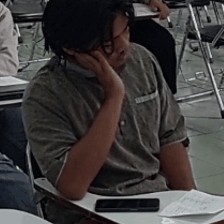

In [19]:
video_tensor = sample_video["video"]
display_gif(video_tensor)

# Training The Model

In [37]:
from transformers import TrainingArguments, Trainer

model_name = model_ckpt.split("/")[-1]
new_model_name = f"{model_name}-finetuned"
num_epochs = 4

args = TrainingArguments(
    new_model_name,
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    report_to="none",
    max_steps=(train_dataset.num_videos // batch_size) * num_epochs,
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [21]:
import evaluate

metric = evaluate.load("accuracy")

In [22]:
# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions."""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [23]:
import torch


def collate_fn(examples):
    """The collation function to be used by `Trainer` to prepare data batches."""
    # permute to (num_frames, num_channels, height, width)
    pixel_values = torch.stack(
        [example["video"].permute(1, 0, 2, 3) for example in examples]
    )
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [24]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

<ipython-input-24-24bc35bb2a98>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [25]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [26]:
train_results = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
0,1.615700,1.539227,0.303030
1,1.644200,1.544884,0.333333
2,1.583700,1.483492,0.272727
3,1.364500,1.436799,0.363636


In [27]:
trainer.evaluate(test_dataset)

{'eval_loss': 1.5894320011138916,
 'eval_accuracy': 0.29577464788732394,
 'eval_runtime': 122.9554,
 'eval_samples_per_second': 0.577,
 'eval_steps_per_second': 0.073,
 'epoch': 3.2265625}

In [28]:
trainer.save_model()
test_results = trainer.evaluate(test_dataset)
trainer.log_metrics("test", test_results)
trainer.save_metrics("test", test_results)
trainer.save_state()

***** test metrics *****
  epoch                   =     3.2266
  eval_accuracy           =     0.2958
  eval_loss               =     1.5894
  eval_runtime            = 0:01:21.67
  eval_samples_per_second =      0.869
  eval_steps_per_second   =       0.11


# Inference

In [29]:
trained_model = VideoMAEForVideoClassification.from_pretrained(new_model_name)

In [30]:
sample_test_video = next(iter(test_dataset))
investigate_video(sample_test_video)

video torch.Size([3, 16, 224, 224])
video_name 4_21.mp4
video_index 23
clip_index 0
aug_index 0
label 3
Video label: 4_menopang_kepala


In [31]:
def run_inference(model, video):
    """Utility to run inference given a model and test video.

    The video is assumed to be preprocessed already.
    """
    # (num_frames, num_channels, height, width)
    perumuted_sample_test_video = video.permute(1, 0, 2, 3)

    inputs = {
        "pixel_values": perumuted_sample_test_video.unsqueeze(0),
        "labels": torch.tensor(
            [sample_test_video["label"]]
        ),  # this can be skipped if you don't have labels available.
    }
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model = model.to(device)

    # forward pass
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    return logits

In [32]:
logits = run_inference(trained_model, sample_test_video["video"])

In [33]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: 2_mengangkat_tangan


# Training Plot

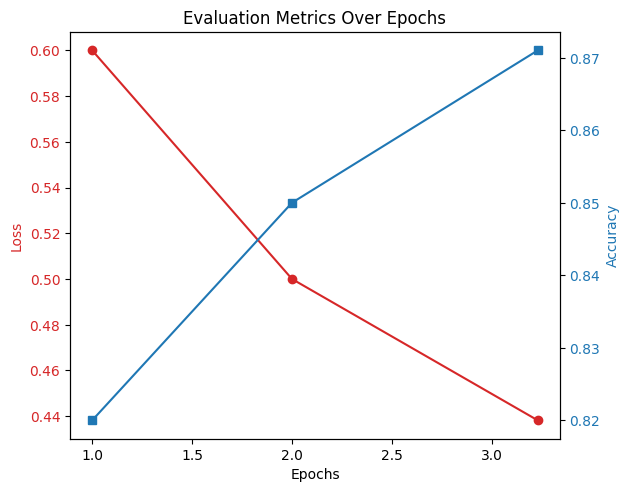

In [34]:
import matplotlib.pyplot as plt

# Sample test results (replace with actual logged values)
epochs = [1, 2, 3.2297]  # Example epoch values
eval_loss = [0.6, 0.5, 0.4382]  # Example loss values
eval_accuracy = [0.82, 0.85, 0.871]  # Example accuracy values

fig, ax1 = plt.subplots()

# Plot loss
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss", color="tab:red")
ax1.plot(epochs, eval_loss, "o-", color="tab:red", label="Eval Loss")
ax1.tick_params(axis="y", labelcolor="tab:red")

# Create a second y-axis for accuracy
ax2 = ax1.twinx()
ax2.set_ylabel("Accuracy", color="tab:blue")
ax2.plot(epochs, eval_accuracy, "s-", color="tab:blue", label="Eval Accuracy")
ax2.tick_params(axis="y", labelcolor="tab:blue")

fig.tight_layout()
plt.title("Evaluation Metrics Over Epochs")
plt.show()

In [41]:
trainer.push_to_hub()

HFValidationError: Repo id must use alphanumeric chars or '-', '_', '.', '--' and '..' are forbidden, '-' and '.' cannot start or end the name, max length is 96: 'videomae-base-finetuned-'.